In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [8]:
# Load the CSV file
url = "https://data.bitcoinity.org/export_data.csv?c=e&currency=USD&data_type=price&r=day&t=l&timespan=all"
df = pd.read_csv(url)

df.head()

,Time,bit-x,bitfinex,bitstamp,cex.io,coinbase,exmo,gemini,itbit,kraken,others
0,2010-07-17 00:00:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049510
1,2010-07-18 00:00:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077975
2,2010-07-19 00:00:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086792
3,2010-07-20 00:00:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077999
4,2010-07-21 00:00:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070463


In [9]:
# Drop the 'bit-x' column if it exists
if "bit-x" in df.columns:
    df.drop(columns=["bit-x"], inplace=True)

# Drop the 'others' column if it exists
if "others" in df.columns:
    df.drop(columns=["others"], inplace=True)
    
# Convert the 'Time' column to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Calculate the Average Price across exchanges, ignoring missing data
df["Average Price"] = df.iloc[:, 1:].mean(axis=1, skipna=True)

# Calculate moving averages
df["111DMA"] = df["Average Price"].rolling(window=111).mean()  # 111-day Moving Average
df["350DMA"] = df["Average Price"].rolling(window=350).mean()  # 350-day Moving Average
df["PiCycleTopIndicator"] = df["111DMA"] / (2 * df["350DMA"])

df

,Time,bitfinex,bitstamp,cex.io,coinbase,exmo,gemini,itbit,kraken,Average Price,111DMA,350DMA,PiCycleTopIndicator
0,2010-07-17 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-18 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-19 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-20 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-21 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5302,2025-01-21 00:00:00+00:00,103903.051966,103850.769468,NaN,103852.520182,104161.261687,NaN,NaN,103842.161025,103921.952866,86583.809373,70550.787861,0.613628
5303,2025-01-22 00:00:00+00:00,104894.371971,104889.302332,NaN,104891.796995,105193.119267,NaN,NaN,104886.361149,104950.990343,86980.313336,70725.779684,0.614912
5304,2025-01-23 00:00:00+00:00,103231.270693,103242.889178,104294.65,103252.592887,103528.292331,NaN,NaN,103235.663947,103464.226506,87355.602202,70892.108922,0.616117
5305,2025-01-24 00:00:00+00:00,105056.998035,105071.589700,NaN,105080.195514,105321.135802,NaN,NaN,105052.634831,105116.510776,87741.488892,71057.852767,0.617395


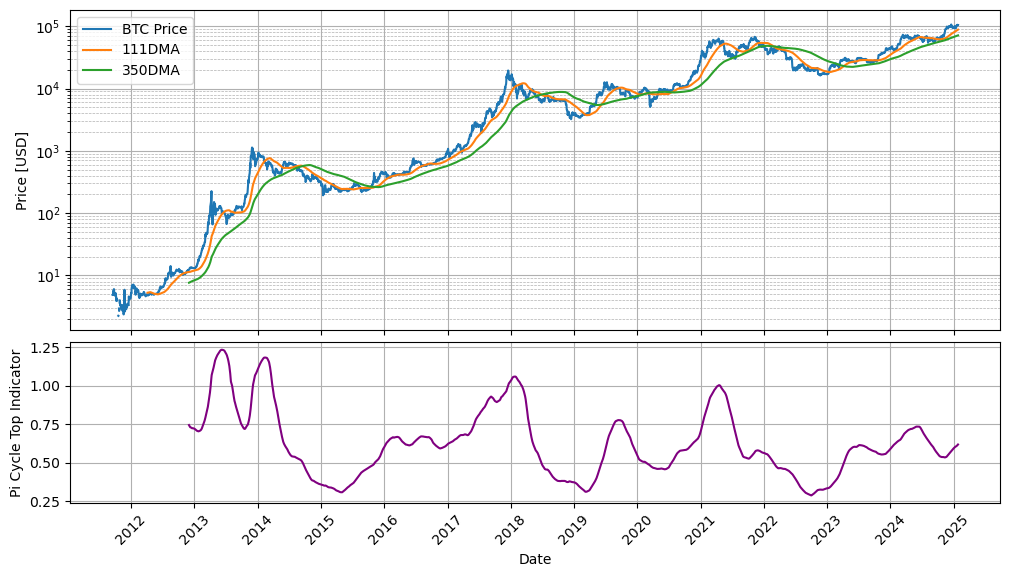

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6.4), gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05}, sharex=True)
axs[0].plot(df['Time'], df['Average Price'], label='BTC Price')
axs[0].plot(df['Time'], df['111DMA'], label='111DMA')
axs[0].plot(df['Time'], df['350DMA'], label='350DMA')
axs[0].set_yscale('log')
axs[0].set_ylabel('Price [USD]')
axs[0].legend()
axs[0].grid(which='major')
axs[0].grid(which='minor', linestyle='--', linewidth=0.5)
axs[1].plot(df['Time'], df['PiCycleTopIndicator'], color='purple')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Pi Cycle Top Indicator')
axs[1].grid()
axs[1].xaxis.set_major_locator(mdates.YearLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
plt.show()

In [29]:
# Import required libraries
import numpy as np
from sklearn.preprocessing import RobustScaler  # Changed to RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 30  # Reduced sequence length
split_ratio = 0.8

# Prepare the data
data = df['PiCycleTopIndicator'].values.reshape(-1, 1)

# Check for and remove any infinite values
data = np.clip(data, np.percentile(data, 1), np.percentile(data, 99))  # Remove outliers
data = np.nan_to_num(data, nan=np.nanmean(data))  # Replace any NaN with mean

# Use RobustScaler instead of MinMaxScaler
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
X, y = create_sequences(data_scaled, sequence_length)

# Split into training and testing sets
train_size = int(len(X) * split_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build a simpler LSTM model
model = Sequential([
    LSTM(16, input_shape=(sequence_length, 1), 
         activation='tanh', 
         return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(8, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='linear')
])

# Compile with a very small learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='huber')  # Using huber loss for robustness

# Add callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, y_pred)
r2 = r2_score(y_test_unscaled, y_pred)

print("\nModel Performance Metrics:")
print(f"Root Mean Square Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
test_dates = df['Time'].values[train_size+sequence_length:]

plt.plot(test_dates, y_test_unscaled, label='Actual', alpha=0.7)
plt.plot(test_dates, y_pred, label='Predicted', alpha=0.7)
plt.title('Pi Cycle Top Indicator: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Pi Cycle Top Indicator')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Epoch 1/50


/Users/joaogaspar/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.8375 - val_loss: 0.3258 - learning_rate: 1.0000e-04
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5363 - val_loss: 0.2569 - learning_rate: 1.0000e-04
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4010 - val_loss: 0.1743 - learning_rate: 1.0000e-04
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3180 - val_loss: 0.1190 - learning_rate: 1.0000e-04
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2503 - val_loss: 0.0790 - learning_rate: 1.0000e-04
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2051 - val_loss: 0.0471 - learning_rate: 1.0000e-04
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1951 - val_loss: 0.0262 - learning_rate: 1.0000e-04
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1629 - val_loss: 0.0242 - learning_rate: 1.0000e-04
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1528 - val_loss: 0.0292 - learning

In [34]:
# Create future dates
last_date = df['Time'].iloc[-1]
end_date = pd.Timestamp('2025-12-31').tz_localize('UTC')  # Add UTC timezone
future_dates = pd.date_range(start=last_date, end=end_date, freq='D')
n_future = len(future_dates)

# Get the last sequence from our data
last_sequence = X_test[-1:]  # Shape: (1, sequence_length, 1)

# Predict iteratively into the future
future_predictions = []
current_sequence = last_sequence.copy()

for _ in range(n_future):
    # Get the prediction for the next value
    next_pred = model.predict(current_sequence)
    future_predictions.append(next_pred[0, 0])
    
    # Update the sequence by removing the first value and adding the prediction
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = next_pred[0, 0]

# Scale back the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [35]:
# Create the full prediction plot
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(df['Time'], df['PiCycleTopIndicator'], 
         label='Historical', color='blue', alpha=0.7)

# Plot test predictions
plt.plot(test_dates, y_pred, 
         label='Test Predictions', color='green', alpha=0.7)

# Plot future predictions
plt.plot(future_dates, future_predictions, 
         label='Future Predictions', color='red', alpha=0.7, linestyle='--')

plt.title('Pi Cycle Top Indicator: Historical, Test, and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Pi Cycle Top Indicator')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Add vertical line to mark present day
plt.axvline(x=last_date, color='black', linestyle=':', alpha=0.5, label='Present Day')

plt.tight_layout()
plt.show()